In [1]:
## Download dataset and required packages if necessary
# !pip install git+https://github.com/neurallatents/nlb_tools.git
# !pip install dandi
# !dandi download https://gui.dandiarchive.org/#/dandiset/000129 -o "../Datasets"

# Dataset Setup


In [2]:
## Imports

# %matplotlib widget # uncomment for interactive plots
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA


In [3]:
## Load dataset
data_dir = os.path.join("..", "Datasets", "000129", "sub-Indy")
dataset = NWBDataset(data_dir, "*train", split_heldout=False)

In [4]:
## Optional resampling
# It may be beneficial to resample the data before you proceed to the analysis sections,
# as they may be fairly memory-intensive. However, we have not tested this notebook at bin sizes
# of over 20 ms, so we cannot guarantee that everything will work as intended at
# those larger bin sizes.
dataset.resample(5)

In [5]:
## Compute speed onset for each reach, for plotting alignment

# Calculate speed and call `calculate_onset`
speed = np.linalg.norm(dataset.data.finger_vel, axis=1)
dataset.data['speed'] = speed
peak_times = dataset.calculate_onset('speed', 0.05)

nans = dataset.data.finger_vel.x.isna().reset_index(drop=True)
dataset.data = dataset.data.iloc[~nans.to_numpy()].reset_index(drop=True)


rates = dataset.data.spikes.to_numpy()
vel = dataset.data.finger_vel.to_numpy()

# Dimensionality Reduction
Dimensionality reduction methods such as Principal Component Analysis (PCA) or Factor Analysis (FA) aim to reduce the number of dimensions (or features) of data while preserving meaningful information. This can be done because many of the features in an array of data have duplicative information.
<br> <br>
Consider neural data recorded from a 96 channel utah array; each channel likely records signals from more than one neuron, with adjacent channels picking up on signals from the same neuron. This means that some of the information in the channel 1 recording is also present in channel 2. Dimensionality reduction methods can remove this degenerate information. 
<br> <br>
Additionally, if each channel is recording from multiple neurons, then the recorded signal is a composite of the signal from each of the neurons. Dimensionality reduction can help to identify the contributions each neuron makes to the final recorded signal.

### PCA 
Dimensionality reduction methods work by assessing the information present across multiple dimensions and consolidating the information to fewer dimensions. In PCA, this is done by creating linear combinations of the data which maximizes the variance in each dimension. 

Take a scatter plot of data, shown below:

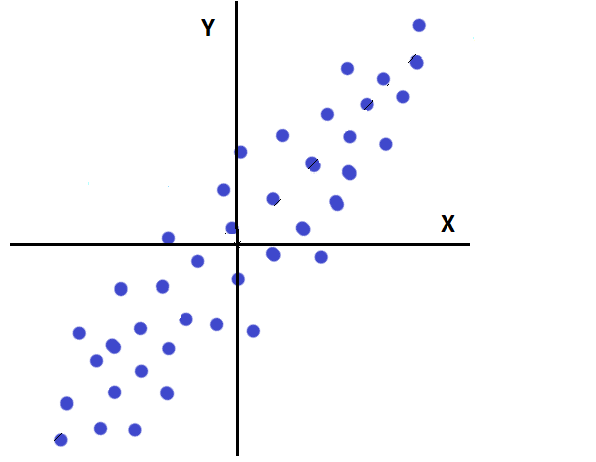

The majority of the variance is not along the X or Y axis, but instead along a diagonal. If we draw a line in the direction of the highest variance, we would get the V1 line shown below. We can then draw another line that's orthogonal to the original and asses the variance it captures.

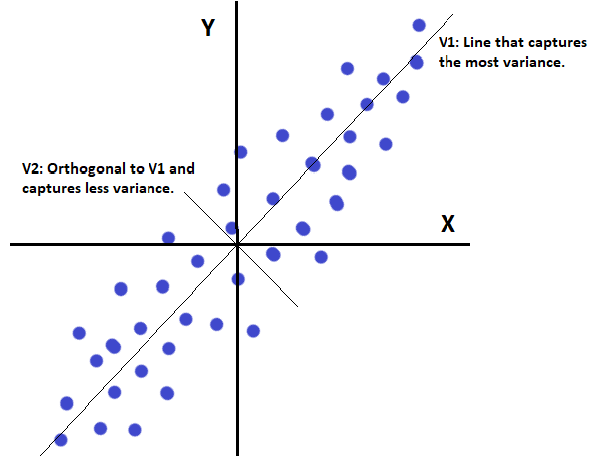

V1 would then become the first principal component (PC1), and V2 would become the second (PC2). We can then establish a new coordinate system where the axes are PC1 and PC2, instead of X and Y, shown below. 


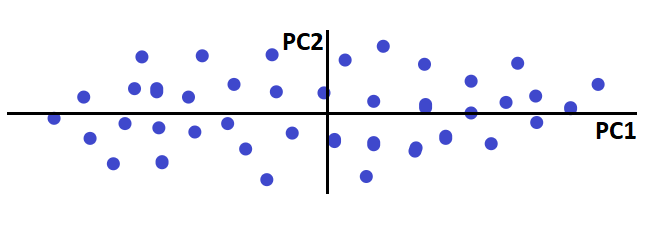

No information has been lost; we are still plotting the same data. However, we now have new axes which capture more variance in the data.

So why do we care about the variance?  


Correlation between blood pressure and Heart attack liklihood: 0.7720336458758538
Correlation between cholesterol and Heart attack liklihood: 0.8172683223123146
Correlation between PC 1 and Heart attack liklihood: 0.817367560814483


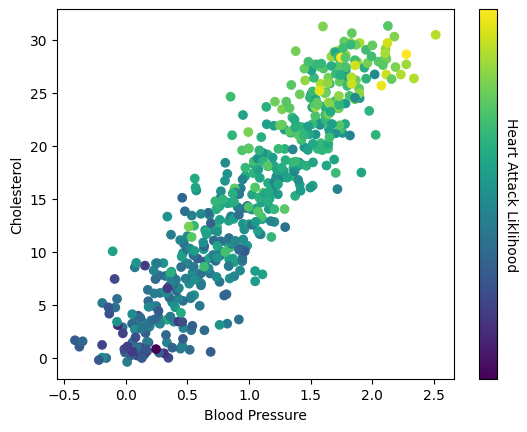

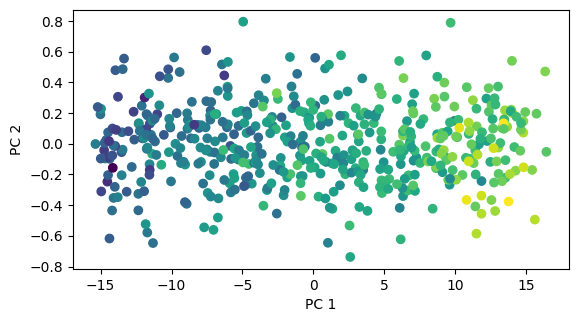

In [46]:
import matplotlib.ticker as mticker

np.random.seed(10)

blood_pressure = np.linspace(0, 2, 500) + np.random.normal(0, .25, 500)
cholesterol = np.linspace(0, 30, 500) + np.random.normal(0, 1, 500)
data = np.array([blood_pressure, cholesterol])
liklihood = np.linspace(0, 1, 500) + np.random.normal(0, .2, 500 )

plt.figure()
plt.scatter(data[0, :], data[1, :], c = liklihood)
plt.xlabel("Blood Pressure")
plt.ylabel("Cholesterol")
cbar = plt.colorbar(ticks=[])
cbar.ax.set_ylabel('Heart Attack Liklihood', rotation=270)
cbar.ax.get_yaxis().labelpad = 15




pca = PCA()
a = pca.fit_transform(data.T)

plt.figure()
plt.scatter(a[:, 0], a[:, 1], c = liklihood)
plt.gca().set_aspect(np.ptp(cholesterol)/np.ptp(blood_pressure))
plt.xlabel("PC 1")
plt.ylabel("PC 2")

print(f"Correlation between blood pressure and Heart attack liklihood: {np.corrcoef(liklihood, blood_pressure)[0, 1]}")
print(f"Correlation between cholesterol and Heart attack liklihood: {np.corrcoef(liklihood, cholesterol)[0, 1]}")
print(f"Correlation between PC 1 and Heart attack liklihood: {np.corrcoef(liklihood, a[:, 0])[0, 1]}")


In [38]:
print(f"Correlation between blood pressure and Heart attack liklihood: {np.corrcoef(liklihood, blood_pressure)[0, 1]}")
print(f"Correlation between cholesterol and Heart attack liklihood: {np.corrcoef(liklihood, cholesterol)[0, 1]}")
print(f"Correlation between PC 1 and Heart attack liklihood: {np.corrcoef(liklihood, a[:, 0])[0, 1]}")

Correlation between blood pressure and Heart attack liklihood: 0.7720336458758538
Correlation between cholesterol and Heart attack liklihood: 0.8224927438752229
Correlation between PC 1 and Heart attack liklihood: 0.8225134695182182


## Applying PCA and examining explained variance

In [8]:

pca = PCA()

pca.fit(rates.T)

PCs = pca.components_

(-1.0, 130.0)

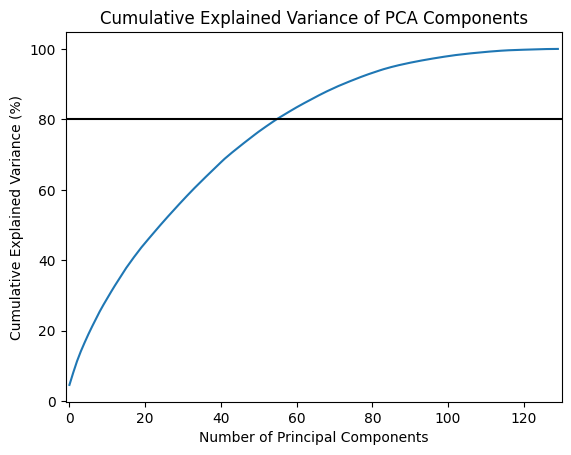

In [9]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.axhline(80, c= 'black')

# Add labels and title
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Cumulative Explained Variance of PCA Components')
plt.xlim([-1, len(pca.explained_variance_ratio_)])


As mentioned above, PCA represents the information present in each component as variance, with the first PCs having the highest variance. Therefore, the cumulative explained variance can be viewed as a proxy for the cumulative information available. The plot above shows that 80% of the variance in the dataset can be captured with around 50 principal components. This means that the dimensions of the dataset can be reduced from 130 to 50 while still capturing the majority of the information present.

# Decoding from reduced data
We can decode from the reduced data. Performance will drop slightly, however, computation time will be decreased.

In [10]:
def smooth(data, window_size = 50):
    # Ensure that data is a 2D array
    data = np.asarray(data)
    if data.ndim != 2:
        raise ValueError("Input data must be a 2D array.")
    
    # Create an empty array to hold the smoothed data
    smoothed_data = np.zeros_like(data)

    # Apply moving average along each column
    for i in range(data.shape[1]):
        smoothed_data[:, i] = np.convolve(data[:, i], np.ones(window_size)/window_size, mode='same')
    
    return smoothed_data

def decode(neural, kinematics):
    gscv = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 9)})
    gscv.fit(neural, kinematics)
    print(f'Decoding R2: {gscv.best_score_}')
    predictions = gscv.predict(neural)
    
    return predictions



n_reduced_dimensions = 50

results = decode(smooth(rates), vel)

reduced_data = PCs[:n_reduced_dimensions, :].T
results = decode(smooth(reduced_data), vel)


Decoding R2: 0.3945580306148597
Decoding R2: 0.3460252834345379


# Latent Dynamics
In addition to consolidating information and reducing the size of the data, dimensionality reduction can reveal underlying patterns and structures in the data. By plotting components against each other, clusters can be seen. 

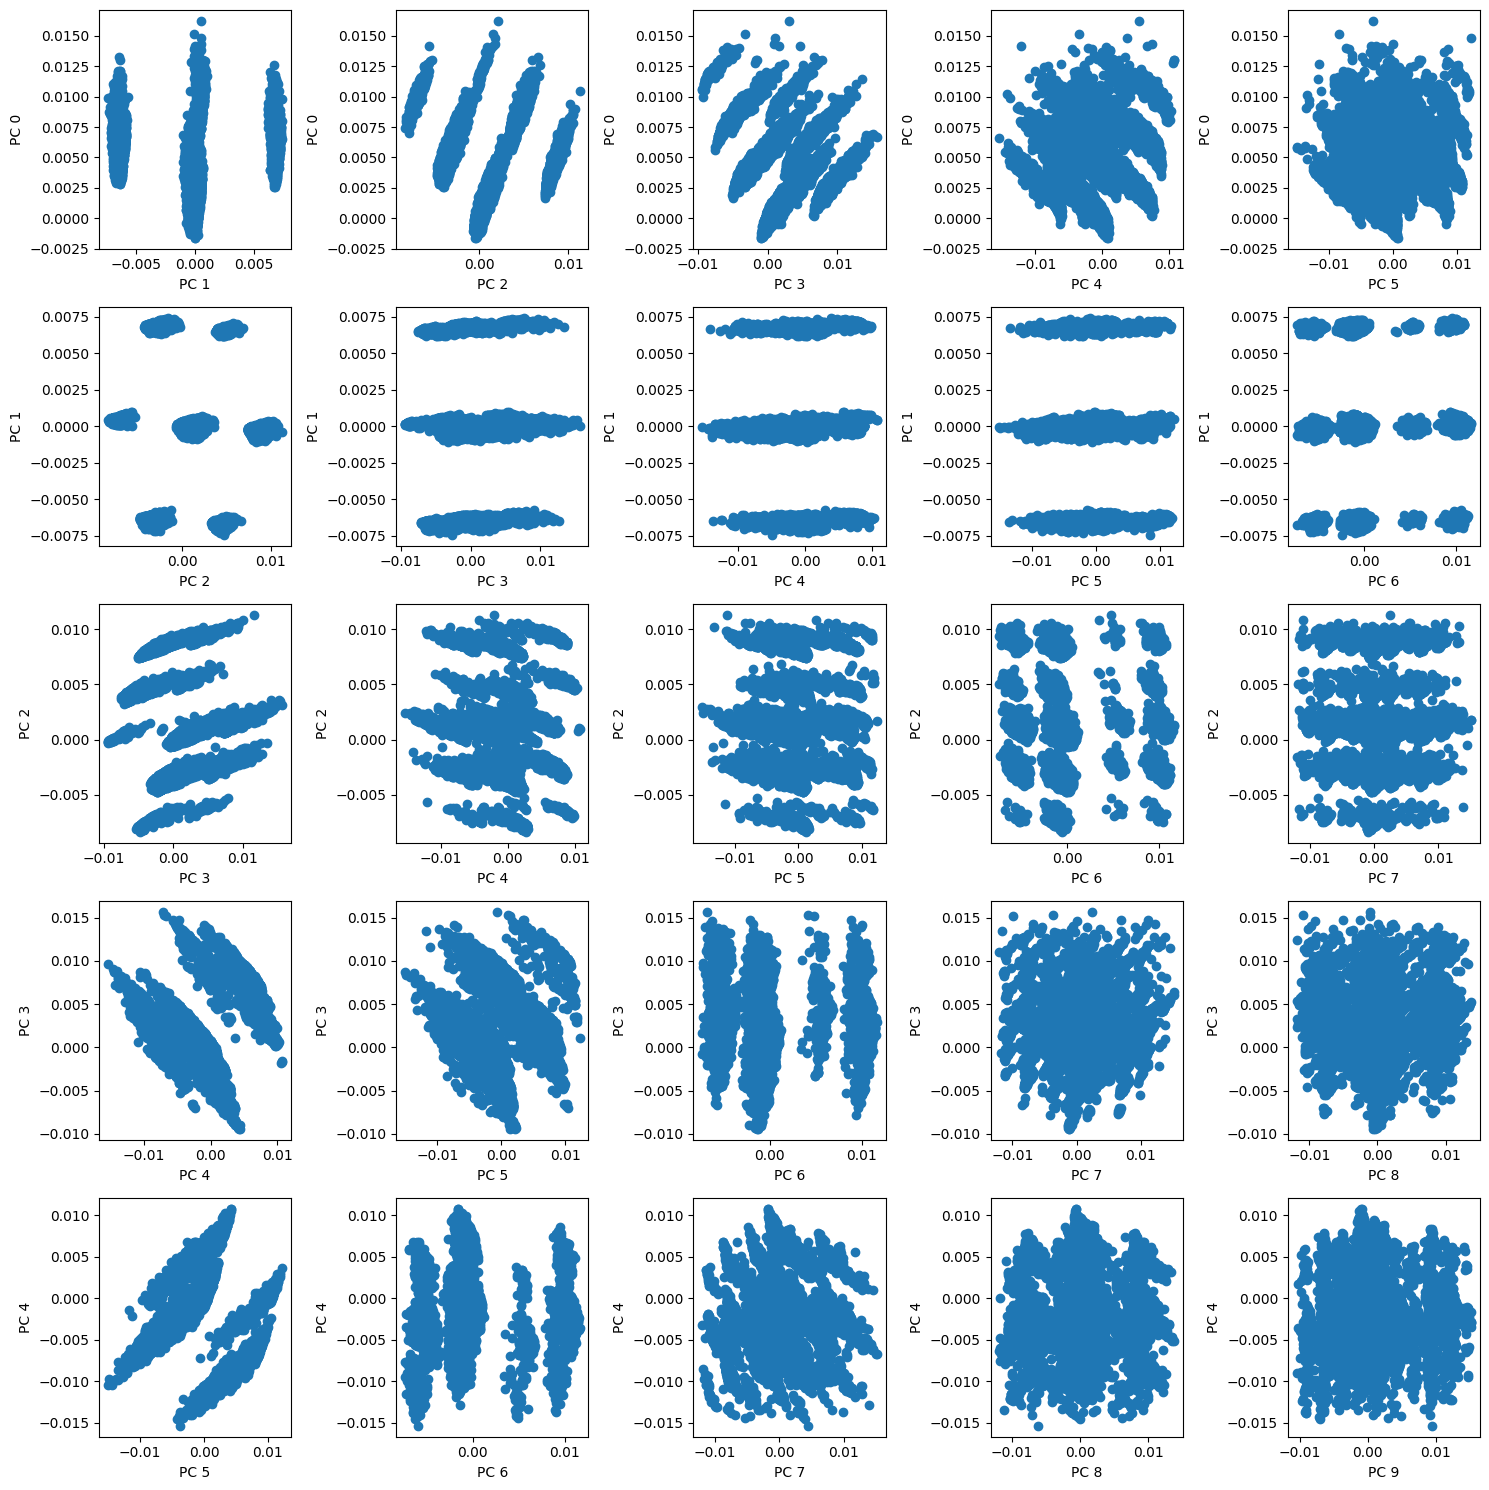

In [11]:
plt.figure(figsize=(15, 15))
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, (i)*5+j+1 )
        plt.scatter(PCs[i+j+1, :], PCs[i, :])
        plt.ylabel(f"PC {i}")
        plt.xlabel(f"PC {i+j+1}")
plt.tight_layout()

C:\Users\riopa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[2 0 0 ... 0 0 0]


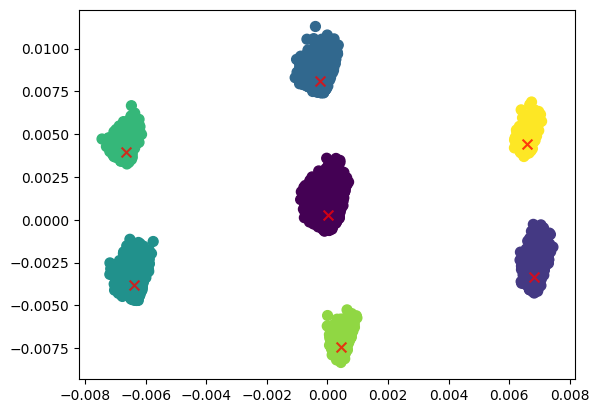

In [12]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def cluster(dim_1, dim_2, k):
    X = np.array([dim_1, dim_2]).T

    # Create KMeans instance with 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=0)

    # Fit the model
    kmeans.fit(X)

    # Predict the clusters
    y_kmeans = kmeans.predict(X)

    # Plot the clusters
    print(y_kmeans)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], marker = 'x', c='red', s=50, alpha=0.75)
    plt.show()
    
    clusters = []

    # Partition the data based on the values array
    for i in range(k):
        clusters.append(X[y_kmeans.flatten() == i])
   
    
    return y_kmeans
    
clusters = cluster(PCs[1, :], PCs[2, :], 7)


In [13]:
print(clusters.shape)
print(rates.shape)

(129760,)
(129760, 130)


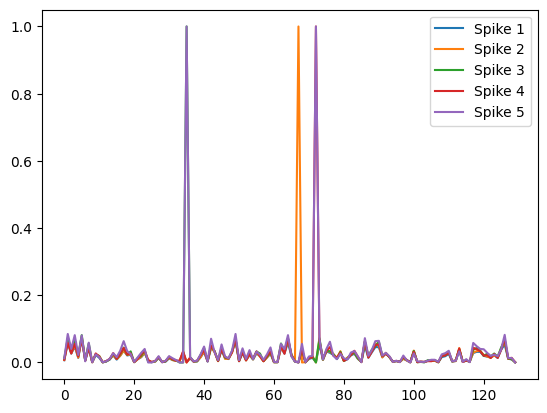

In [17]:
def plot_avg_rates(spikes, inds):
    K = max(inds)+1
    K = 5
    plt.figure()
    labels = [f'Cluster {i}' for i in range(K)]
    for i in range(K):
        OGspikes = spikes[inds== i, :]
        avgSpikes = OGspikes.mean(axis=0)
        stdSpike = OGspikes.std(axis=0)
        plt.plot(avgSpikes, label='Spike '+str(i+1))
        # plt.fill_between(range(130), avgSpikes - stdSpike, avgSpikes + stdSpike, alpha=0.2, )
        

    plt.legend()
        
plot_avg_rates(rates, clusters)